Starting Flower client...
FlowerClient.__init__ called


	Instead, use the `flower-supernode` CLI command to start a SuperNode as shown below:

		$ flower-supernode --insecure --superlink='<IP>:<PORT>'

	To view all available options, run:

		$ flower-supernode --help

	Using `start_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      
INFO :      Received: train message f0063a89-bf00-457e-9d70-7eb486a180df


FlowerClient.fit called
Images from: DatasetGoogleDrive
Creating dataloaders...
Dataloaders created successfully.
2 657 164
Salvando FL-DatasetGoogleDrive-FL


epoch,train_loss,valid_loss,accuracy,time
0,0.387071,1.788140,0.506098,00:26
1,0.277655,28.355650,0.506098,00:24
2,0.243835,0.278970,0.865854,00:24
3,0.229492,3.251230,0.573171,00:24
4,0.197064,4.974999,0.512195,00:24
5,0.184914,1.144256,0.634146,00:24
6,0.155886,0.838462,0.750000,00:24
7,0.132159,0.056851,0.981707,00:24
8,0.110548,0.021892,0.993902,00:24
9,0.093862,0.011801,0.993902,00:24


FlowerClient.get_parameters called


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4f0e6351-0bf7-47bc-976d-a9cdc584dd56


FlowerClient.evaluate called
Images from: DatasetGoogleDrive
Creating dataloaders...
Dataloaders created successfully.


              precision    recall  f1-score   support

Kidney_stone       1.00      1.00      1.00       103
      Normal       1.00      1.00      1.00       103

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206



INFO :      Sent reply
INFO :      
INFO :      Received: train message ae898453-3462-415d-9199-6c238d047bc3


FlowerClient.fit called
Images from: DatasetGoogleDrive
Creating dataloaders...
Dataloaders created successfully.
2 657 164
Salvando FL-DatasetGoogleDrive-FL


epoch,train_loss,valid_loss,accuracy,time
0,0.048068,0.116997,0.951219,00:23
1,0.096078,9.211224,0.664634,00:24
2,0.130001,13.501757,0.506098,00:23
3,0.170381,9.509774,0.493902,00:23
4,0.160837,0.599046,0.859756,00:23
5,0.156460,1.520099,0.713415,00:23
6,0.138853,0.023011,0.993902,00:25
7,0.123826,0.008920,1.000000,00:27
8,0.101496,0.015581,1.000000,00:35
9,0.084666,0.019326,0.993902,00:39


FlowerClient.get_parameters called


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 1a7b85a1-0805-41fb-8a3d-8388d727f901


FlowerClient.evaluate called
Images from: DatasetGoogleDrive
Creating dataloaders...
Dataloaders created successfully.


              precision    recall  f1-score   support

Kidney_stone       1.00      1.00      1.00       103
      Normal       1.00      1.00      1.00       103

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206



INFO :      Sent reply
INFO :      
INFO :      Received: train message 3017aaf5-e1ef-44d9-af14-c6252a8d9292


FlowerClient.fit called
Images from: DatasetGoogleDrive
Creating dataloaders...
Dataloaders created successfully.
2 657 164
Salvando FL-DatasetGoogleDrive-FL


epoch,train_loss,valid_loss,accuracy,time
0,0.058189,0.245800,0.902439,00:24
1,0.063136,0.469040,0.835366,00:24
2,0.109768,1.007692,0.750000,00:23
3,0.162245,4.059581,0.603659,00:24
4,0.138604,1.346569,0.817073,00:24
5,0.114144,0.642652,0.750000,00:24
6,0.095044,0.000509,1.000000,00:24
7,0.081062,0.036507,0.987805,00:24
8,0.072322,0.003841,1.000000,00:24
9,0.068124,0.000838,1.000000,00:23


FlowerClient.get_parameters called


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 24249f45-19e5-4536-89e5-5297d31dfd21


FlowerClient.evaluate called
Images from: DatasetGoogleDrive
Creating dataloaders...
Dataloaders created successfully.


              precision    recall  f1-score   support

Kidney_stone       1.00      1.00      1.00       103
      Normal       1.00      1.00      1.00       103

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206



INFO :      Sent reply
INFO :      
INFO :      Received: train message eebf7bc1-848a-4191-9209-4f53aa6a19a3


FlowerClient.fit called
Images from: DatasetGoogleDrive
Creating dataloaders...
Dataloaders created successfully.
2 657 164
Salvando FL-DatasetGoogleDrive-FL


epoch,train_loss,valid_loss,accuracy,time
0,0.015680,0.087509,0.945122,00:24
1,0.042276,0.570376,0.859756,00:24
2,0.087281,3.076992,0.567073,00:24
3,0.116182,0.601958,0.890244,00:24
4,0.124572,1.030464,0.817073,00:24
5,0.125146,0.079001,0.981707,00:24
6,0.106947,0.167627,0.963415,00:24
7,0.094975,0.053071,0.969512,00:24
8,0.080647,0.003615,1.000000,00:24
9,0.067244,0.004227,1.000000,00:24


INFO :      Sent reply


FlowerClient.get_parameters called


INFO :      
INFO :      Received: evaluate message 6ff7f413-952b-4775-b749-7753712bb1de


FlowerClient.evaluate called
Images from: DatasetGoogleDrive
Creating dataloaders...
Dataloaders created successfully.


              precision    recall  f1-score   support

Kidney_stone       0.99      1.00      1.00       103
      Normal       1.00      0.99      1.00       103

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206



INFO :      Sent reply
INFO :      
INFO :      Received: train message 1b72864b-ee38-4e08-8328-e56d95c7d368


FlowerClient.fit called
Images from: DatasetGoogleDrive
Creating dataloaders...
Dataloaders created successfully.
2 657 164
Salvando FL-DatasetGoogleDrive-FL


epoch,train_loss,valid_loss,accuracy,time
0,0.028670,0.007785,1.000000,00:24
1,0.041905,1.809387,0.634146,00:24
2,0.046910,0.470346,0.890244,00:24
3,0.066961,0.035698,0.981707,00:24
4,0.065330,0.168941,0.969512,00:23
5,0.051280,0.077457,0.981707,00:24
6,0.047833,0.273384,0.951219,00:24
7,0.044065,0.024812,0.987805,00:24
8,0.034784,0.000185,1.000000,00:24
9,0.033591,0.000103,1.000000,00:24


FlowerClient.get_parameters called


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8ab8f282-c404-4911-be4b-1cae78778e22


FlowerClient.evaluate called
Images from: DatasetGoogleDrive
Creating dataloaders...
Dataloaders created successfully.


              precision    recall  f1-score   support

Kidney_stone       1.00      1.00      1.00       103
      Normal       1.00      1.00      1.00       103

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206



INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message 2e93dfd7-0ba8-4792-aacc-a7f94b805ead
INFO :      Disconnect and shut down


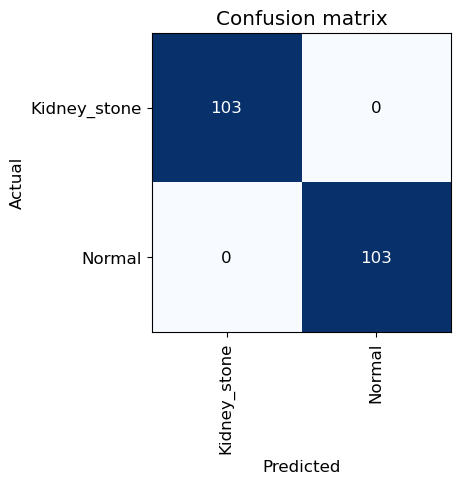

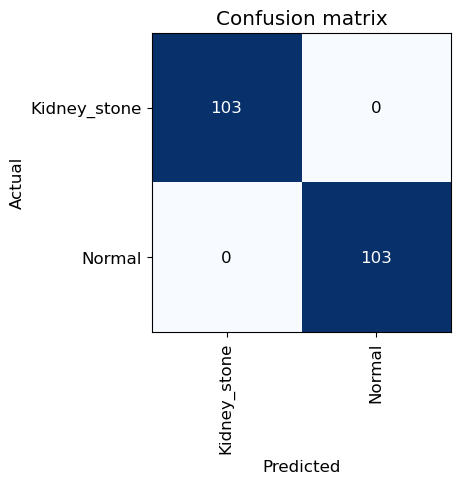

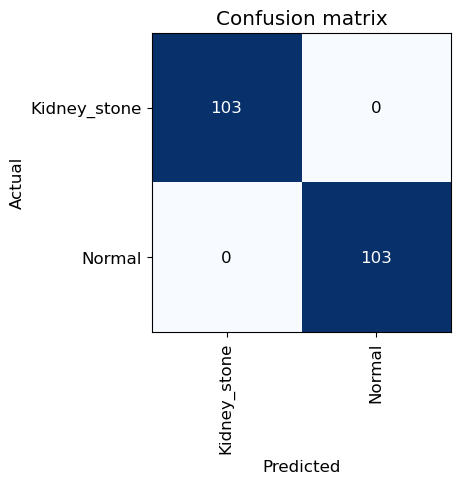

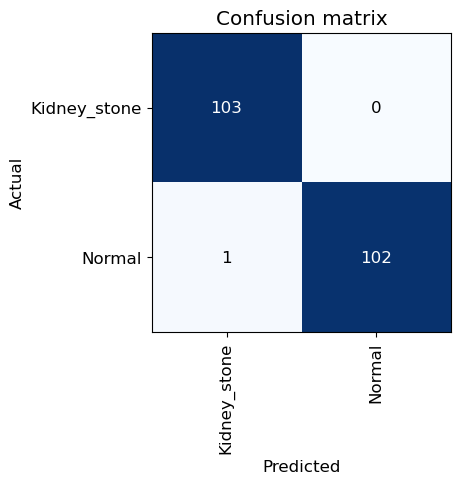

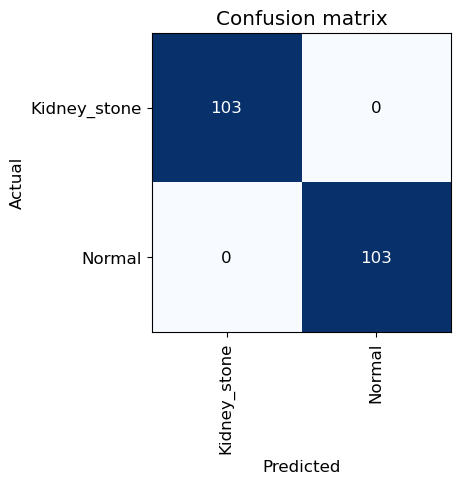

In [1]:
import sys
sys.stdout.flush()

import sys
import flwr as fl
from task import carregar_e_processar_dados, treinar_modelo_flower, avaliar_modelo_flower
import torch.nn as nn
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *
import json

class FlowerClient(fl.client.NumPyClient):
    def __init__(self):
        print("FlowerClient.__init__ called")
        self.model = nn.Sequential(create_body(xresnet50(), pretrained=False), create_head(nf=2048, n_out=2))

    def get_parameters(self, config):
        print("FlowerClient.get_parameters called")
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters):
        print("FlowerClient.set_parameters called")
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = dict((k, torch.tensor(v)) for k, v in params_dict)
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        print("FlowerClient.fit called")
        dls = carregar_e_processar_dados('DatasetGoogleDrive', 'train')
        torch.cuda.empty_cache()
        learn = treinar_modelo_flower(self.model, dls, 1)
        self.model = learn.model
        return self.get_parameters({}), len(dls.train_ds), {}

    def evaluate(self, parameters, config):
        print("FlowerClient.evaluate called")
        dls = carregar_e_processar_dados('DatasetGoogleDrive', 'test')
        torch.cuda.empty_cache()
        metricas = avaliar_modelo_flower(self.model, dls)
        return metricas[0], len(dls.valid_ds), {"accuracy": metricas[1], "loss": metricas[0], "predicted_labels": json.dumps(metricas[2]), "true_labels": json.dumps(metricas[3]), "preds": json.dumps(metricas[4])}

if __name__ == "__main__":
    print("Starting Flower client...")
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=FlowerClient().to_client(),
    )

